## Residual Network 구현 및 학습

In [1]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 하이퍼 파라미터

In [2]:
EPOCHS = 10

## Residual Unit 구현

In [3]:
class ResidualUnit(tf.keras.Model):
    def __init__(self, filter_in, filter_out, kernel_size):
        super(ResidualUnit, self).__init__()
        
        Layers = tf.keras.layers
        self.bn1 = Layers.BatchNormalization()
        self.conv1 = Layers.Conv2D(filter_out, kernel_size, padding='same')
        
        self.bn2 = Layers.BatchNormalization()
        self.conv2 = Layers.Conv2D(filter_out, kernel_size, padding='same')
        
        # 필터의 갯수가 다를 경우 맞추어 주어야 함
        if filter_in == filter_out:
            self.identity = lambda x: x
        else:
            self.identity = Layers.Conv2D(filter_out, (1,1), padding='same')

    def call(self, x, training=False, mask=None):
        h = self.bn1(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv1(h)
        
        h = self.bn2(h, training=training)
        h = tf.nn.relu(h)
        h = self.conv2(h)
        
        #  convolution을 수행 후 처음 입력값(x)을 더해줌
        return self.identity(x) + h

## Residual Layer 구현

In [4]:
class ResnetLayer(tf.keras.Model):
    def __init__(self, filter_in, filters, kernel_size):
        super(ResnetLayer, self).__init__()
        self.sequence = list()
        
        # 필터를 더해주어서 쌍으로 만드는 방식
        # [filter_in] + list(filters) => [16] + [32, 32, 32] => [16, 32, 32, 32]
        # filters => [32, 32, 32]
        # zip은 쌍으로 만들어 주며, 쌍이 맞지 않으면 쌍이 있는 값까지만 반복됨
        # zip([16, 32, 32, 32], [32, 32, 32]) => (16, 32), (32, 32), (32, 32)
        
        for f_in, f_out in zip([filter_in] + list(filters), filters):
            self.sequence.append(ResidualUnit(f_in, f_out, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x

## 모델 정의

In [5]:
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        Layers = tf.keras.layers
        # 입력 이미지(28 x 28 x 1)에 대해서 첫번째 Convolution 작업을 진행하기 위한 설정
        self.conv1 = Layers.Conv2D(8, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.res1 = ResnetLayer(8, (16, 16), (3, 3)) # 28x28x16
        self.pool1 = Layers.MaxPool2D((2, 2)) # 14x14x16
        
        self.res2 = ResnetLayer(16, (32, 32), (3, 3)) # 14x14x32
        self.pool2 = Layers.MaxPool2D((2, 2)) # 7x7x32
        
        self.res3 = ResnetLayer(32, (64, 64), (3, 3)) # 7x7x64
        
        self.flatten = Layers.Flatten()
        self.dense1 = Layers.Dense(128, activation='relu')
        self.dense2 = Layers.Dense(10, activation='softmax')
        
    def call(self, x, training=False, mask=None):
        x = self.conv1(x)
        
        x = self.res1(x, training=training)
        x = self.pool1(x)
        x = self.res2(x, training=training)
        x = self.pool2(x)
        x = self.res3(x, training=training)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
        

## 학습, 테스트 루프 정의

In [6]:
# Implement training loop
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

# Implement algorithm test
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images, training=False)

    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## 데이터셋 준비


(28, 28)


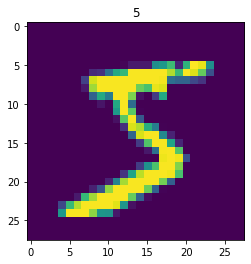

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 이미지 구조 및 값 확인
#print(len(x_train), len(x_test))
#print(x_train.shape)
print(x_train[0].shape)

# 이미지와 레이블 확인
plt.figure()
plt.imshow(x_train[0])
plt.title(y_train[0])
plt.show()


x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 학습 환경 정의
### 모델 생성, 손실함수, 최적화 알고리즘, 평가지표 정의

In [8]:
# Create model
model = ResNet()

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## 학습 루프 동작

In [9]:
# 시간측정 필요. 노트북의 경우 1 epoch당 8분 정도 소요됨
t = time.time()
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    ct = time.time()
    print('{} seconds elapsed.'.format(ct - t))
    t = ct
    

Epoch 1, Loss: 0.14658445119857788, Accuracy: 95.97666931152344, Test Loss: 0.14317943155765533, Test Accuracy: 97.16999816894531
508.8457977771759 seconds elapsed.
Epoch 2, Loss: 0.06698042154312134, Accuracy: 98.23999786376953, Test Loss: 0.09982042014598846, Test Accuracy: 97.7699966430664
470.4569892883301 seconds elapsed.
Epoch 3, Loss: 0.05082543566823006, Accuracy: 98.57833099365234, Test Loss: 0.05076877027750015, Test Accuracy: 98.50999450683594
503.7274281978607 seconds elapsed.
Epoch 4, Loss: 0.04018716886639595, Accuracy: 98.8566665649414, Test Loss: 0.04284198582172394, Test Accuracy: 98.81999969482422
512.2761132717133 seconds elapsed.
Epoch 5, Loss: 0.034387435764074326, Accuracy: 98.99166870117188, Test Loss: 0.047184284776449203, Test Accuracy: 98.7699966430664
511.40090680122375 seconds elapsed.
Epoch 6, Loss: 0.028965575620532036, Accuracy: 99.18500518798828, Test Loss: 0.06680302321910858, Test Accuracy: 98.19999694824219
512.2599084377289 seconds elapsed.
Epoch 7, 